<center><font size=10>ETL - Extract Transform Load</font></center><br>

<font size=10>Libraries</font>

In [1]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from urllib.request import HTTPError, urlopen
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from collections import Counter
from unidecode import unidecode
from bs4 import BeautifulSoup
import plotly.plotly as py
import plotly.tools as tls
import pandas as pd
import numpy as np
import lxml.html
import requests
import pickle
import sys
import re

%matplotlib inline
plt.rcParams['figure.figsize'] = (14,8)
plt.style.use('seaborn-darkgrid')
init_notebook_mode(connected=True)
pd.set_option("display.max_columns", 100)

# Extract - Scrapper

In [2]:
def clean_scraping_dict(list_to_clean):
    '''
    input: list_to_clean - type list - list scrapped
    output: list_clean - type list - list scrapped clean
    
    This function return list with scrapped elements cleaned
    '''
    return [ltc.replace('\n', '').replace('\t', '').replace('\xa0', '').replace(' ', '-')
            .replace('ejournée' ,'').replace(' ','') for ltc in list_to_clean] # list_clean

def to_web_name(real_name):
    '''
    input: real_name - type list - name of teams scrapped
    output: web_name - type list - name of teams used in URL
    
    This function return list that contains team names used in URL
    '''
    web_name = []
    for r in real_name:
        r = r.lower()
        r = r.replace(' ','-').replace('\xa0', '').replace(' ', '')
        web_name.append(unidecode(r))
    return web_name

def create_dict(year, league):
    '''
    input: year - type int - year team names to scrap 
           championnat - type str - championnat team names to scrap
    output: dict_league - type dict - dict with key as team names in classement and values 
                                            as teams names used in URL
    
    This function return dict of with key as team names in classement 
    and values as teams names used in URL
    '''
    dict_league = {}
    year = str(year)
    URL = "http://www.sports.fr/football/" + league + "/" + year + "/classements/classement-general.html"
    page = urlopen(URL).read()
    html = lxml.html.fromstring(page)
    scraping = html.xpath("//td[@class='tl nowrap']") 
    
    data = {}
    team_name_list = [sc.text_content() for sc in scraping]
    team_name_list = clean_scraping_dict(team_name_list)
    web_name_list = to_web_name(team_name_list)
    
    for wn, tn in zip(web_name_list, team_name_list):
        dict_league[tn] = wn
    return dict_league

league, year = "angleterre", 2015
create_dict(str(year), league)

{'Arsenal': 'arsenal',
 'Aston-Villa': 'aston-villa',
 'Burnley': 'burnley',
 'Chelsea': 'chelsea',
 'Crystal-Palace': 'crystal-palace',
 'Everton': 'everton',
 'Hull-City': 'hull-city',
 'Leicester-City': 'leicester-city',
 'Liverpool': 'liverpool',
 'Manchester-City': 'manchester-city',
 'Manchester-United': 'manchester-united',
 'Newcastle': 'newcastle',
 'Queens-Park-Rangers': 'queens-park-rangers',
 'Southampton': 'southampton',
 'Stoke-City': 'stoke-city',
 'Sunderland': 'sunderland',
 'Swansea-City': 'swansea-city',
 'Tottenham': 'tottenham',
 'West-Brom': 'west-brom',
 'West-Ham': 'west-ham'}

In [3]:
def clean_scraping(list_to_clean):
    '''
    input: list_to_clean - type list - list scrapped
    output: list_clean - type list - list scrapped clean
    
    This function return list with scrapped elements cleaned
    '''
    return [ltc.replace('\n', '').replace('\t', '').replace('\xa0', '').replace(' ', '')
            .replace('ejournée' ,'').replace('ej.' ,'') for ltc in list_to_clean] # list_clean

def recover_main_football_data(league, team, year):
    '''
    input: championnat - type str - league we want to scrap
           team - type str - team result we want to scrap
           year - type int - year result we want to scrap
    output: df - type pd.DataFrame - df with results of a specific team over a year
    
    This function return the results of team over a year as dataframe object
    '''
    URL = "http://www.sports.fr/football/" + league + "/" + str(year) + "/calendrier/" + team + ".html" 
    page = urlopen(URL).read()
    html = lxml.html.fromstring(page)
    scraping = html.xpath("//tr[@class='alt']//td") 
    
    data = {}
    data_list = [sc.text_content() for sc in scraping]
    results_list = data_list[3::8]
    dates_list = data_list[0::8]
    team_home_list = data_list[4::8]
    team_away_list = data_list[6::8]
    played_day_list = data_list[2::8]
    score_list = data_list[5::8]
    
    #Results
    results_list_cleaned = clean_scraping(results_list)
    data["Results"] = results_list_cleaned
    
    #Date
    dates_list_cleaned = clean_scraping(dates_list)
    data["Date"] = dates_list_cleaned
    
    #Team Name Home
    team_home_list_cleaned = clean_scraping(team_home_list)
    data["Team_Home"] = team_home_list_cleaned
    
    #Team Name Away
    team_away_list_cleaned = clean_scraping(team_away_list)
    data["Team_Away"] = team_away_list_cleaned
    
    # Played Day
    played_day_list_cleaned = clean_scraping(played_day_list)
    data["Played_Day"] = played_day_list_cleaned
    
    # Goal(s) scored Team Home/Away
    score_list_cleaned = clean_scraping(score_list)
    score_list_home_cleaned = '-'.join(score_list_cleaned)[0::4]
    data["Score_Home"] = list(map(int, score_list_home_cleaned))
    score_away_list_cleaned = '-'.join(score_list_cleaned)[2::4]
    data["Score_Away"] = list(map(int, score_away_list_cleaned))
    data["Team_Concerned"] = team.title()
    data["Football_Season"] = int(year)
    
    df = pd.DataFrame(data)
    assert(df.shape == (38, 9))
    return df

league, team, year = "angleterre", "arsenal", 2017
recover_main_football_data(league, team, year)

,Date,Football_Season,Played_Day,Results,Score_Away,Score_Home,Team_Away,Team_Concerned,Team_Home
0,14/08/16,2017,1,D,4,3,Liverpool,Arsenal,Arsenal
1,20/08/16,2017,2,N,0,0,Arsenal,Arsenal,LeicesterCity
2,27/08/16,2017,3,V,3,1,Arsenal,Arsenal,Watford
3,10/09/16,2017,4,V,1,2,Southampton,Arsenal,Arsenal
4,17/09/16,2017,5,V,4,1,Arsenal,Arsenal,HullCity
5,24/09/16,2017,6,V,0,3,Chelsea,Arsenal,Arsenal
6,02/10/16,2017,7,V,1,0,Arsenal,Arsenal,Burnley
7,15/10/16,2017,8,V,2,3,SwanseaCity,Arsenal,Arsenal
8,22/10/16,2017,9,N,0,0,Middlesbrough,Arsenal,Arsenal
9,29/10/16,2017,10,V,4,1,Arsenal,Arsenal,Sunderland


# Transform - Pandas Skills
## Featuring

In [4]:
def get_complete_df(league, start_year, end_year):
    '''
    input: league - type str - championnat we want to scrap
           start_year - type int - first year we want to scrap
           end_year - type int - last year we want to scrap
    output: df_league - type pd.DataFrame - dataframe of all teams results in a specific league
    
    This function return a full dataframe of all teams results in a specific league between 2 dates
    '''
    frames = []

    for year in range(start_year, end_year + 1):
        dict_angleterre = create_dict(str(year), league)
        for team in dict_angleterre.values():
            df_foot = recover_main_football_data(league, team, year)
            frames.append(df_foot)
    return pd.concat(frames) #df_league

df_england = get_complete_df("angleterre", 2016, 2017)
print(df_england.shape)
df_england.head()

(1520, 9)


,Date,Football_Season,Played_Day,Results,Score_Away,Score_Home,Team_Away,Team_Concerned,Team_Home
0,08/08/15,2016,1,V,2,4,Sunderland,Leicester-City,LeicesterCity
1,15/08/15,2016,2,V,2,1,LeicesterCity,Leicester-City,WestHam
2,22/08/15,2016,3,N,1,1,Tottenham,Leicester-City,LeicesterCity
3,29/08/15,2016,4,N,1,1,LeicesterCity,Leicester-City,Bournemouth
4,13/09/15,2016,5,V,2,3,AstonVilla,Leicester-City,LeicesterCity


In [5]:
def get_season_time(month):
    '''
    input: month - type int - month of the game
    output: season_time - type str - season of the game
    
    This function return the season when the match was played.
    '''
    if (month == 8)| (month == 7):
        return 0
    elif (month >= 9) & (month < 12):
        return 1
    elif (month >= 12) | (month < 3):
        return 2
    return 3

df_england["Date"] =  pd.to_datetime(df_england["Date"], format='%d/%m/%y', errors='coerce') 
df_england.set_index(['Date'], inplace=True)

df_england["Year"] = df_england.index.year
df_england["Month"] = df_england.index.month
df_england["Day"] = df_england.index.day
df_england["Day_in_Week"] = df_england.index.dayofweek
df_england["Season"] = df_england["Month"].apply(lambda x: get_season_time(x))
df_england.head()

,Football_Season,Played_Day,Results,Score_Away,Score_Home,Team_Away,Team_Concerned,Team_Home,Year,Month,Day,Day_in_Week,Season
Date,,,,,,,,,,,,,
2015-08-08,2016,1,V,2,4,Sunderland,Leicester-City,LeicesterCity,2015,8,8,5,0
2015-08-15,2016,2,V,2,1,LeicesterCity,Leicester-City,WestHam,2015,8,15,5,0
2015-08-22,2016,3,N,1,1,Tottenham,Leicester-City,LeicesterCity,2015,8,22,5,0
2015-08-29,2016,4,N,1,1,LeicesterCity,Leicester-City,Bournemouth,2015,8,29,5,0
2015-09-13,2016,5,V,2,3,AstonVilla,Leicester-City,LeicesterCity,2015,9,13,6,1


In [6]:
def get_big6_opponent(opponent):
    '''
    input: opponent - type str - opponent team name
           big_six - type list - list of big six teams in Premier League
    output: is_op_big6 - type int - 1 if opponent is in big 6, 0 otherwise
    
    This function return if a team plays against a big 6 team (in London) or not
    '''
    big_six = ["Arsenal", "Chelsea", "Tottenham", "Liverpool", "ManchesterCity", "ManchesterUnited"]
    if opponent in big_six:
        if opponent in big_six[:3]:
            return pd.Series((1, 1)) #is_Big6_Opponent and is_Big6_London
        else:
            return pd.Series((1, 0))
    return pd.Series((0, 0))

# Get Oponnent #
df_england["Opponent"] = np.where(df_england["Team_Concerned"] == df_england["Team_Home"],
                                        df_england["Team_Away"], df_england["Team_Home"])

# Get Bool is_Big6_Opponent is_Big6_London #
df_england[['is_Big6_Opponent', 'is_Big6_London_Opponent']] = df_england.apply(
    lambda row: pd.Series(get_big6_opponent(row['Opponent'])), axis=1)
df_england.head()

,Football_Season,Played_Day,Results,Score_Away,Score_Home,Team_Away,Team_Concerned,Team_Home,Year,Month,Day,Day_in_Week,Season,Opponent,is_Big6_Opponent,is_Big6_London_Opponent
Date,,,,,,,,,,,,,,,,
2015-08-08,2016,1,V,2,4,Sunderland,Leicester-City,LeicesterCity,2015,8,8,5,0,LeicesterCity,0,0
2015-08-15,2016,2,V,2,1,LeicesterCity,Leicester-City,WestHam,2015,8,15,5,0,WestHam,0,0
2015-08-22,2016,3,N,1,1,Tottenham,Leicester-City,LeicesterCity,2015,8,22,5,0,LeicesterCity,0,0
2015-08-29,2016,4,N,1,1,LeicesterCity,Leicester-City,Bournemouth,2015,8,29,5,0,Bournemouth,0,0
2015-09-13,2016,5,V,2,3,AstonVilla,Leicester-City,LeicesterCity,2015,9,13,6,1,LeicesterCity,0,0


In [7]:
def points_won(result):
    '''
    input: result - type str - result of a team V (Victories), D (Defeat) or N (Nul=Draw)
    output: int_result - type int - return points won function of result
    
    This function return the number of points won function of the result
    '''
    if result == "V":
        return 3 #int_result
    elif result == "D":
        return 0
    return 1

df_england["Points_Won"] = df_england["Results"].apply(lambda x: points_won(x))
df_england["Difference"] = np.where(df_england["Team_Concerned"] == df_england["Team_Home"],
                                   df_england["Score_Home"] - df_england["Score_Away"],
                                   df_england["Score_Away"] - df_england["Score_Home"])
df_england.head()

,Football_Season,Played_Day,Results,Score_Away,Score_Home,Team_Away,Team_Concerned,Team_Home,Year,Month,Day,Day_in_Week,Season,Opponent,is_Big6_Opponent,is_Big6_London_Opponent,Points_Won,Difference
Date,,,,,,,,,,,,,,,,,,
2015-08-08,2016,1,V,2,4,Sunderland,Leicester-City,LeicesterCity,2015,8,8,5,0,LeicesterCity,0,0,3,-2
2015-08-15,2016,2,V,2,1,LeicesterCity,Leicester-City,WestHam,2015,8,15,5,0,WestHam,0,0,3,1
2015-08-22,2016,3,N,1,1,Tottenham,Leicester-City,LeicesterCity,2015,8,22,5,0,LeicesterCity,0,0,1,0
2015-08-29,2016,4,N,1,1,LeicesterCity,Leicester-City,Bournemouth,2015,8,29,5,0,Bournemouth,0,0,1,0
2015-09-13,2016,5,V,2,3,AstonVilla,Leicester-City,LeicesterCity,2015,9,13,6,1,LeicesterCity,0,0,3,-1


In [8]:
def get_cumul(row, str_col_name, df):
    '''
    input: row - row of the apply dataframe we work on 
           str_col_name - column name we want to cumul
           df - type pd.DataFrame - dataframe we work on
    output: cum_points - int - cumul point at a specific date in a football season
    
    This function return the cumul of a specific column at every moment of the season
    '''
    date = row.name
    season = row.Football_Season
    team = row.Team_Concerned
    
    cum_points = df[(df.index <= date) 
                  & (df.Football_Season == season) 
                  & (df.Team_Concerned == team)][str_col_name].sum()
    return cum_points 

df_england["Cumul_Points"] = df_england.apply(get_cumul, axis=1, args=('Points_Won', df_england,))
df_england["Cumul_Difference"] = df_england.apply(get_cumul, axis=1, args=('Difference', df_england,))
df_england.head()

,Football_Season,Played_Day,Results,Score_Away,Score_Home,Team_Away,Team_Concerned,Team_Home,Year,Month,Day,Day_in_Week,Season,Opponent,is_Big6_Opponent,is_Big6_London_Opponent,Points_Won,Difference,Cumul_Points,Cumul_Difference
Date,,,,,,,,,,,,,,,,,,,,
2015-08-08,2016,1,V,2,4,Sunderland,Leicester-City,LeicesterCity,2015,8,8,5,0,LeicesterCity,0,0,3,-2,3,-2
2015-08-15,2016,2,V,2,1,LeicesterCity,Leicester-City,WestHam,2015,8,15,5,0,WestHam,0,0,3,1,6,-1
2015-08-22,2016,3,N,1,1,Tottenham,Leicester-City,LeicesterCity,2015,8,22,5,0,LeicesterCity,0,0,1,0,7,-1
2015-08-29,2016,4,N,1,1,LeicesterCity,Leicester-City,Bournemouth,2015,8,29,5,0,Bournemouth,0,0,1,0,8,-1
2015-09-13,2016,5,V,2,3,AstonVilla,Leicester-City,LeicesterCity,2015,9,13,6,1,LeicesterCity,0,0,3,-1,11,-2


In [9]:
def get_classement(row, df):
    '''
    input: row - row of the apply dataframe we work on
           df - type pd.DataFrame - dataframe we work on
    output: cum_points - type int - classement at a specific date in a football season
    
    This function return the classement of a team at every moment of the season
    '''
    date = row.name
    season = row.Football_Season
    team = row.Team_Concerned
    
    classement = df[(df.index <= date) 
                    & (df.Football_Season == season)][["Team_Concerned", "Points_Won", "Difference"]]\
                    .groupby("Team_Concerned").sum().sort_values(by=["Points_Won", 'Difference'], 
                                                                 ascending=False).index.get_loc(team) + 1
    return classement

df_england["Classement"] = df_england.apply(get_classement, axis=1, args=(df_england,))
df_england.head()

,Football_Season,Played_Day,Results,Score_Away,Score_Home,Team_Away,Team_Concerned,Team_Home,Year,Month,Day,Day_in_Week,Season,Opponent,is_Big6_Opponent,is_Big6_London_Opponent,Points_Won,Difference,Cumul_Points,Cumul_Difference,Classement
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-08,2016,1,V,2,4,Sunderland,Leicester-City,LeicesterCity,2015,8,8,5,0,LeicesterCity,0,0,3,-2,3,-2,4
2015-08-15,2016,2,V,2,1,LeicesterCity,Leicester-City,WestHam,2015,8,15,5,0,WestHam,0,0,3,1,6,-1,2
2015-08-22,2016,3,N,1,1,Tottenham,Leicester-City,LeicesterCity,2015,8,22,5,0,LeicesterCity,0,0,1,0,7,-1,2
2015-08-29,2016,4,N,1,1,LeicesterCity,Leicester-City,Bournemouth,2015,8,29,5,0,Bournemouth,0,0,1,0,8,-1,3
2015-09-13,2016,5,V,2,3,AstonVilla,Leicester-City,LeicesterCity,2015,9,13,6,1,LeicesterCity,0,0,3,-1,11,-2,2


## Dataframe Manipulation

In [10]:
df_england_months_scores = df_england[["Score_Away", "Score_Home"]].resample('m').sum().copy()
df_england_months_scores.head()

,Score_Away,Score_Home
Date,,
2015-08-31,110,88
2015-09-30,72,104
2015-10-31,102,108
2015-11-30,72,108
2015-12-31,92,132


In [11]:
df_england_resume_teams = df_england[["Team_Concerned", "Football_Season", "Points_Won", "Difference"]]\
                            .groupby(['Team_Concerned', 'Football_Season']).agg({
                                'Points_Won': ['sum', 'mean'],
                                'Difference': ['sum', 'mean', 'min', 'max', 'size']})

df_england_resume_teams

Points_Won           Difference            \
                                         sum      mean        sum      mean   
Team_Concerned    Football_Season                                             
Arsenal           2016                    71  1.868421         29  0.763158   
                  2017                    75  1.973684         33  0.868421   
Aston-Villa       2016                    17  0.447368         -7 -0.184211   
Bournemouth       2016                    42  1.105263        -22 -0.578947   
                  2017                    46  1.210526        -12 -0.315789   
Burnley           2017                    40  1.052632        -16 -0.421053   
Chelsea           2016                    50  1.315789          6  0.157895   
                  2017                    93  2.447368         52  1.368421   
Crystal-Palace    2016                    42  1.105263         -4 -0.105263   
                  2017                    41  1.078947        -11 -0.289474   
Everton           2016                    47  1.236842          4  0.105263   
                  2017                    61  1.605263         18  0.473684   
Hull-City         2017                    34  0.894737        -29 -0.763158   
Leicester-City    2016                    81  2.131579         -2 -0.052632   
                  2017                    44  1.157895        -27 -0.710526   
Liverpool         2016                    60  1.578947         13  0.342105   
                  2017                    76  2.000000         36  0.947368   
Manchester-City   2016                    66  1.736842        -22 -0.578947   
                  2017                    78  2.052632          1  0.026316   
Manchester-United 2016                    66  1.736842        -22 -0.578947   
                  2017                    69  1.815789         -3 -0.078947   
Middlesbrough     2017                    28  0.736842        -26 -0.684211   
Newcastle         2016                    37  0.973684        -21 -0.552632   
Norwich           2016                    34  0.894737        -28 -0.736842   
Southampton       2016                    63  1.657895         18  0.473684   
                  2017                    46  1.210526         -7 -0.184211   
Stoke-City        2016                    51  1.342105        -10 -0.263158   
                  2017                    44  1.157895        -15 -0.394737   
Sunderland        2016                    39  1.026316        -14 -0.368421   
                  2017                    24  0.631579        -40 -1.052632   
Swansea-City      2016                    47  1.236842        -10 -0.263158   
                  2017                    41  1.078947        -11 -0.289474   
Tottenham         2016                    70  1.842105         34  0.894737   
                  2017                    86  2.263158         60  1.578947   
Watford           2016                    45  1.184211        -10 -0.263158   
                  2017                    40  1.052632        -28 -0.736842   
West-Brom         2016                    43  1.131579         -2 -0.052632   
                  2017                    45  1.184211        -18 -0.473684   
West-Ham          2016                    62  1.631579         -2 -0.052632   
                  2017                    45  1.184211          7  0.184211   

                                                
                                  min max size  
Team_Concerned    Football_Season               
Arsenal           2016             -4   4   38  
                  2017             -3   4   38  
Aston-Villa       2016             -4   6   38  
Bournemouth       2016             -4   3   38  
                  2017             -4   5   38  
Burnley           2017             -4   3   38  
Chelsea           2016             -3   4   38  
                  2017             -3   5   38  
Crystal-Palace    2016             -4   3   38  
                  2017             -5   4   38  

In [12]:
print("Classement 2017:")
df_england_resume_teams["Points_Won"]["sum"].xs(2017, level='Football_Season').sort_values(ascending=False)

Classement 2017:


Team_Concerned
Chelsea              93
Tottenham            86
Manchester-City      78
Liverpool            76
Arsenal              75
Manchester-United    69
Everton              61
Southampton          46
Bournemouth          46
West-Brom            45
West-Ham             45
Stoke-City           44
Leicester-City       44
Swansea-City         41
Crystal-Palace       41
Watford              40
Burnley              40
Hull-City            34
Middlesbrough        28
Sunderland           24
Name: sum, dtype: int64

In [13]:
df_england_resume_teams_classement = df_england_resume_teams.copy()

df_england_resume_teams_classement.reset_index(level = ['Football_Season', 'Team_Concerned'], inplace=True)
df_england_resume_teams_classement["Points_Season"] = \
                                        df_england_resume_teams_classement["Points_Won"]["sum"]
df_england_resume_teams_classement["Difference_Season"] = \
                                        df_england_resume_teams_classement["Difference"]["sum"]
del df_england_resume_teams_classement["Points_Won"]
del df_england_resume_teams_classement["Difference"]
df_england_resume_teams_classement.sort_values(by=["Football_Season", "Points_Season", "Difference_Season"],
                                           ascending=False, inplace=True)
df_england_resume_teams_classement.head()

,Team_Concerned,Football_Season,Points_Season,Difference_Season
,,,,
7,Chelsea,2017,93,52
33,Tottenham,2017,86,60
18,Manchester-City,2017,78,1
16,Liverpool,2017,76,36
1,Arsenal,2017,75,33


In [14]:
df_england_resume_teams_classement.loc[df_england_resume_teams_classement.Football_Season == 2016, 
                                        "Classement"] = np.arange(1, 21)
df_england_resume_teams_classement.loc[df_england_resume_teams_classement.Football_Season == 2017, 
                                        "Classement"] = np.arange(1, 21)

df_england_resume_teams_classement = df_england_resume_teams_classement.groupby(["Team_Concerned", 
                                            "Football_Season"])["Classement"].sum().to_frame()
df_england_resume_teams_classement.head()

Classement
Team_Concerned Football_Season            
Arsenal        2016                    2.0
               2017                    5.0
Aston-Villa    2016                   20.0
Bournemouth    2016                   16.0
               2017                    9.0

In [15]:
pd.concat([df_england_resume_teams, df_england_resume_teams_classement], axis=1).head(8)

(Points_Won, sum)  (Points_Won, mean)  \
Team_Concerned Football_Season                                          
Arsenal        2016                            71            1.868421   
               2017                            75            1.973684   
Aston-Villa    2016                            17            0.447368   
Bournemouth    2016                            42            1.105263   
               2017                            46            1.210526   
Burnley        2017                            40            1.052632   
Chelsea        2016                            50            1.315789   
               2017                            93            2.447368   

                                (Difference, sum)  (Difference, mean)  \
Team_Concerned Football_Season                                          
Arsenal        2016                            29            0.763158   
               2017                            33            0.868421   
Aston-Villa    2016                            -7           -0.184211   
Bournemouth    2016                           -22           -0.578947   
               2017                           -12           -0.315789   
Burnley        2017                           -16           -0.421053   
Chelsea        2016                             6            0.157895   
               2017                            52            1.368421   

                                (Difference, min)  (Difference, max)  \
Team_Concerned Football_Season                                         
Arsenal        2016                            -4                  4   
               2017                            -3                  4   
Aston-Villa    2016                            -4                  6   
Bournemouth    2016                            -4                  3   
               2017                            -4                  5   
Burnley        2017                            -4                  3   
Chelsea        2016                            -3                  4   
               2017                            -3                  5   

                                (Difference, size)  Classement  
Team_Concerned Football_Season                                  
Arsenal        2016                             38         2.0  
               2017                             38         5.0  
Aston-Villa    2016                             38        20.0  
Bournemouth    2016                             38        16.0  
               2017                             38         9.0  
Burnley        2017                             38        16.0  
Chelsea        2016                             38        10.0  
               2017                             38         1.0

## Analysis & Visualization

In [16]:
colors_club = {"Arsenal": "#EF0107", "Chelsea": "#034694", "Tottenham": '#1B1A30', "Watford": "#ffeb00"}

### Matplotlib

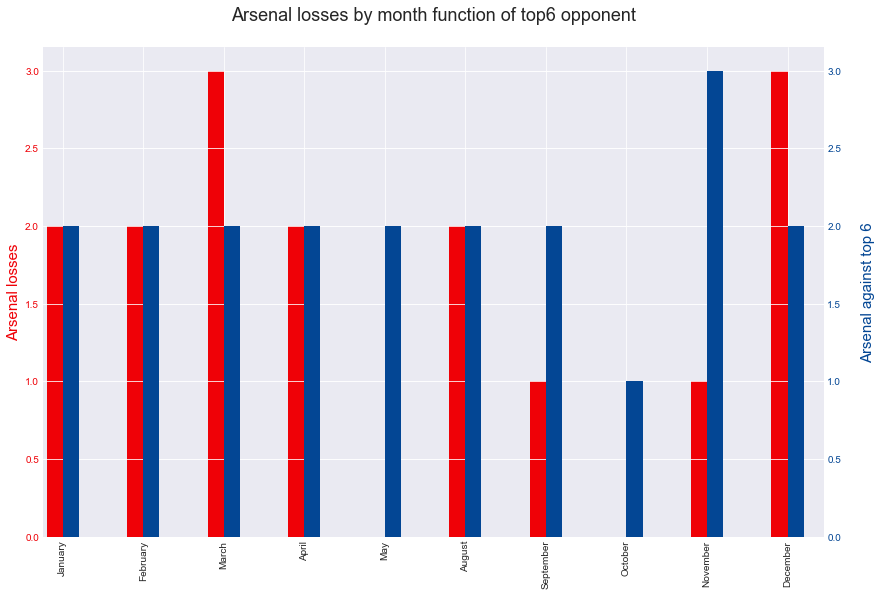

In [17]:
# Data Preparation #
df_b6 = df_england[["Team_Concerned", "Month", "Results", "is_Big6_Opponent"]]\
    .groupby(["Team_Concerned", "Month"]).sum().reset_index(["Team_Concerned", "Month"])

df_l = df_england[df_england['Results'] == 'D'][["Team_Concerned", "Month", "Results", "is_Big6_Opponent"]]\
    .pivot_table(index='Month', columns='Team_Concerned', values='Results', fill_value=0, aggfunc='count')\
    .unstack().to_frame().rename(columns={0:'Results'}).reset_index(["Team_Concerned", "Month"])

df_arsenal = pd.concat([df_b6[df_b6.Team_Concerned == "Arsenal"][["is_Big6_Opponent"]], 
                        df_l[df_l.Team_Concerned == "Arsenal"]], axis=1)

football_months = ["January", "February", "March", "April", "May", "August", "September",
                  "October", "November", "December"]

# Plot #
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111) 
ax2 = ax.twinx()
width = 0.2
df_arsenal.Results.plot(kind='bar', color=colors_club["Arsenal"], 
                                              ax=ax, width=width, position=1)
df_arsenal.is_Big6_Opponent.plot(kind='bar', color=colors_club["Chelsea"], 
                                              ax=ax2, width=width, position=0)
ax.set_title('Arsenal losses by month function of top6 opponent\n', fontsize=18)
ax.set_ylabel('Arsenal losses', color=colors_club["Arsenal"], fontsize=15)
ax2.set_ylabel('\nArsenal against top 6', color=colors_club["Chelsea"], fontsize=15)
ax.tick_params('y', colors=colors_club["Arsenal"])
ax2.tick_params('y', colors=colors_club["Chelsea"])
plt.xticks(np.arange(10), football_months, fontsize=15)
plt.show()

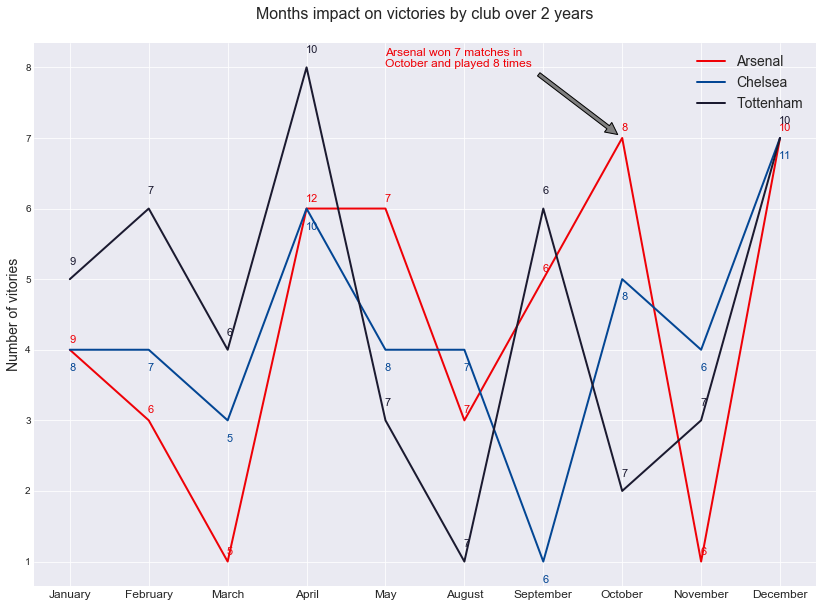

In [18]:
# Data Preparation #
# Wins
df_england_wins = df_england[df_england['Results'] == 'V'][["Team_Concerned", "Month", "Results"]]\
                        .pivot_table(index='Month', columns='Team_Concerned', values='Results', 
                        fill_value=0, aggfunc='count').unstack().to_frame().rename(columns={0:'Results'})

ars_w_val, che_w_val, to_w_val, _ = [df_england_wins.iloc[df_england_wins.index\
                                                       .get_level_values('Team_Concerned')== t]["Results"]\
                                                       .ravel() for t in colors_club.keys()]

# Played
df_england_played = df_england[["Team_Concerned", "Month", "Results"]]\
                        .pivot_table(index='Month', columns='Team_Concerned', values='Results', 
                        fill_value=0, aggfunc='count').unstack().to_frame().rename(columns={0:'Results'})

ars_p_val, che_p_val, to_p_val, _ = [df_england_played.iloc[df_england_played.index\
                                                       .get_level_values('Team_Concerned')== t]["Results"]\
                                                       .ravel() for t in colors_club.keys()]

# Plot #
mpl_fig = plt.figure(figsize = (14, 10))
plt.plot(ars_w_val, color = colors_club["Arsenal"], linewidth=2)
plt.plot(che_w_val, color = colors_club["Chelsea"], linewidth=2)
plt.plot(to_w_val, color = colors_club["Tottenham"], linewidth=2)
for m in range(len(football_months)):
    plt.text(m - 0.01, ars_w_val[m] + 0.1, str(ars_p_val[m]), fontsize=11, color=colors_club["Arsenal"])
    plt.text(m - 0.01, che_w_val[m] - 0.3, str(che_p_val[m]), fontsize=11, color=colors_club["Chelsea"])
    plt.text(m - 0.01, to_w_val[m] + 0.2, str(to_p_val[m]), fontsize=11, color=colors_club["Tottenham"])
plt.annotate('Arsenal won 7 matches in\nOctober and played 8 times', color=colors_club["Arsenal"], 
             xy=(7, 7), xytext=(4, 8), arrowprops=dict(facecolor='grey', shrink=0.05), fontsize=12)
plt.title("Months impact on victories by club over 2 years\n", fontsize=16)
plt.legend([club for club in colors_club.keys()], fontsize=14)
plt.ylabel("Number of vitories", fontsize=14)
plt.xticks(np.arange(10), football_months, fontsize=12)
plt.show()

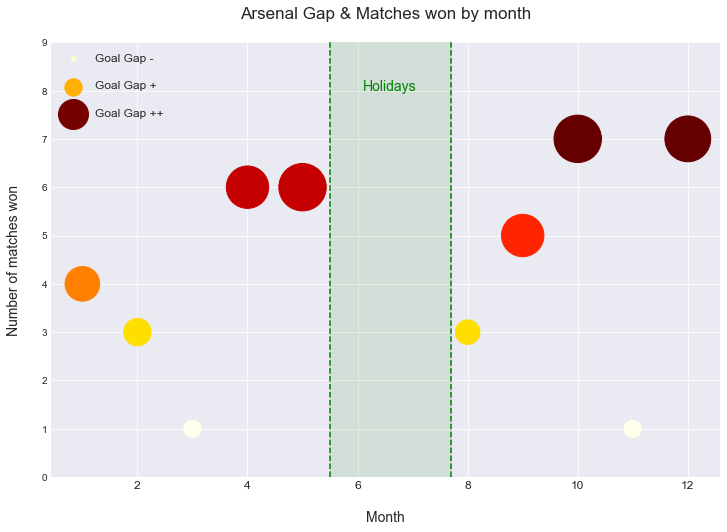

In [19]:
# Data Preparation #
ars_stats = df_england[(df_england['Results'] == 'V') & (df_england['Team_Concerned'] == 'Arsenal')]\
                    [["Team_Concerned", "Difference", "Month"]].groupby(['Month'])\
                    .agg({'Difference': ['sum', 'size']}).reset_index(['Month'])

# Plot #
cmap = plt.cm.hot
ars_colors = ars_stats["Difference"]['size'].values - max(ars_stats["Difference"]['size'].values) - 1
ars_colors = ars_colors * 250 / max(abs(ars_colors))
ars_colors = [abs(int(a)) for a in ars_colors]

mpl_fig = plt.figure(figsize = (12, 8))
plt.scatter(y = ars_stats["Difference"]['size'].values, x = ars_stats["Month"], 
            s = (ars_stats["Difference"]['sum'].values) * 150, color = cmap(ars_colors))
plt.title("\n", fontsize=16)
plt.xlabel("\nMonth", fontsize=14)
plt.ylabel("Number of matches won\n", fontsize=14)
plt.axvline(x=5.5, color='green', ls='--')
plt.axvline(x=7.7, color='green', ls='--')
plt.axvspan(5.5, 7.7, alpha=0.1, color = 'green')
plt.text(6.1, 8, "Holidays", fontsize=14, color='green')
gll = plt.scatter([],[], s=20, marker='o', color='#FFFFC4')
gl = plt.scatter([],[], s=300, marker='o', color='#FFB000')
ga = plt.scatter([],[], s=900, marker='o', color='#740000')
plt.legend((gll,gl,ga),
       ('Goal Gap -', '\nGoal Gap +\n', 'Goal Gap ++'),
       scatterpoints=1, loc='upper left', ncol=1, fontsize=12)
plt.title("Arsenal Gap & Matches won by month\n", fontsize=17)
plt.xticks(fontsize=12)
plt.ylim((0, 9))
plt.show()

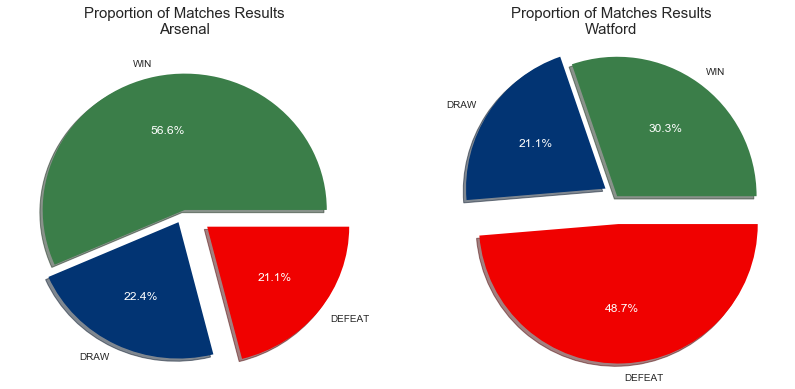

In [20]:
# Data Preparation #
ars_games_won = len(df_england[(df_england["Team_Concerned"] == "Arsenal") 
                             & (df_england["Results"] == 'V')])
wat_games_won = len(df_england[(df_england["Team_Concerned"] == "Watford") 
                                 & (df_england["Results"] == 'V')])
ars_games_draws = len(df_england[(df_england["Team_Concerned"] == "Arsenal") 
                             & (df_england["Results"] == 'N')])
wat_games_draws = len(df_england[(df_england["Team_Concerned"] == "Watford") 
                                 & (df_england["Results"] == 'N')])
ars_games_losses = len(df_england[(df_england["Team_Concerned"] == "Arsenal") 
                             & (df_england["Results"] == 'D')])
wat_games_losses = len(df_england[(df_england["Team_Concerned"] == "Watford") 
                                 & (df_england["Results"] == 'D')])

# Plot #
fig = plt.figure(figsize=(14, 10)) 
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 0.9])
colors = ['#3b7e49', '#023473', '#F00100']
explode = (0, 0.1, 0.2)
ax0 = plt.subplot(gs[0])
_, _, autotexts0 = ax0.pie([ars_games_won, ars_games_draws, ars_games_losses], explode=explode, 
                           labels=["WIN", "DRAW", "DEFEAT"], colors=colors, autopct='%1.1f%%', shadow=True)
ax0.set_title("Proportion of Matches Results\nArsenal", fontsize=15)
for autotext in autotexts0:
    autotext.set_color('white')
    autotext.set_size(12)

ax1 = plt.subplot(gs[1])
_, _, autotexts1 = ax1.pie([wat_games_won, wat_games_draws, wat_games_losses], explode=explode, 
                           labels=["WIN", "DRAW", "DEFEAT"], colors=colors, autopct='%1.1f%%', shadow=True)
ax1.set_title("Proportion of Matches Results\nWatford", fontsize=15)
for autotext in autotexts1:
    autotext.set_color('white')
    autotext.set_size(12)

plt.axis('equal')
plt.show()

### Plotly

In [21]:
# Data preparation #
ars_season = df_england[["Football_Season", "Team_Concerned", "Cumul_Points"]]\
                        [(df_england.Football_Season==2017) & (df_england.Team_Concerned == "Arsenal")]\
                        .resample('d').sum().copy()
ars_season = ars_season[ars_season.Football_Season > 0]["Cumul_Points"]

wat_season = df_england[["Football_Season", "Team_Concerned", "Cumul_Points"]]\
                        [(df_england.Football_Season==2017) & (df_england.Team_Concerned == "Watford")]\
                        .resample('d').sum().copy()
wat_season = wat_season[wat_season.Football_Season > 0]["Cumul_Points"]

# Visualization #
mpl_fig = plt.figure(figsize=(13,6.5))
ax = mpl_fig.add_subplot(111)
ax.plot(ars_season.index, ars_season, colors_club["Arsenal"], wat_season, colors_club["Watford"])
ax.set_title('Arsenal vs Watford Season (2017)', fontsize=18)
ax.set_ylabel("Points won", fontsize=15)

plotly_fig = tls.mpl_to_plotly(mpl_fig)
iplot(plotly_fig)

In [22]:
# Data preparation #
df_ars_2017 = df_england[["Points_Won", "Football_Season", "Team_Concerned"]][(df_england.Team_Concerned=="Arsenal") & (df_england.Football_Season == 2017)]
df_ars_2017 = df_ars_2017[["Points_Won"]].resample('SM').sum() #Semi Month

# Visualization #
mpl_fig = plt.figure(figsize=(13,6.5))
ax = mpl_fig.add_subplot(111)
ax.bar(df_ars_2017.index,
       height=df_ars_2017.Points_Won,
       color=colors_club["Arsenal"])
ax.set_title('Moyennes Pollution en 03 par an')

plotly_fig = tls.mpl_to_plotly(mpl_fig)
iplot(plotly_fig)

# Loader

In [23]:
df_england["Date"] = df_england.index
df_england.to_csv("data/data.csv", index=False) #csv
df_england.to_json("data/data.json", orient="split") #json

Clément Tailleur - Data Scientist